# Backward Propagation with Mini-Batch Stochastic Gradiant Descent

## Spesifikasi
- Jumlah hidden layer maksimal 10
- Jumlah node dalam setiap hidden layer dapat bervariasi
- Fully-connected layer
- Fungsi aktivasi berupa sigmoid untuk semua hidden layer maupun output layer
- Node output berjumlah 1
- Program memberikan pilihan untuk menggunakan momentum atau tidak
- Program mengimplementasikan mini-batch stochastic gradient descent
- Implementasi incremental dengan setting batch-size=1 dan implementasi batch dengan setting batchsize=jumlah
data.

Algoritma ini akan diuji dengan data weather (tennis) yang diambil dari Weka

In [9]:
from scipy.io import arff
import numpy as np
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [10]:
class NeuralNetwork():
    def __init__(self, 
                 input_nodes,
                 hidden_nodes=[],
                 output_nodes=1,
                 batch_size=4,
                 learning_rate=1e-4,
                 momentum=0,
                 threshold=0.5):
        assert(input_nodes >= 1)
        assert(0 <= len(hidden_nodes) <= 10)
        assert(batch_size >= 1)
        
        self.layers = self._init_layers(input_nodes, hidden_nodes, output_nodes)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.threshold = threshold
        
        self.params_values = self._init_weights()

        
    def _init_layers(self, input_nodes, hidden_nodes, output_nodes):
        layers = []
        layers.append(input_nodes)
        for hidden_layer in hidden_nodes:
            layers.append(hidden_layer)
        layers.append(output_nodes)
        
        return layers
    
    def _init_grads_values(self):
        grads_values = {}
        for idx in range(1, len(self.layers)):
            layer_input_size = self.layers[idx-1]
            layer_output_size = self.layers[idx]
            grads_values['W' + str(idx)] = np.zeros([layer_output_size, layer_input_size])
            grads_values['b' + str(idx)] = np.zeros([layer_output_size])
        return grads_values
        
    def _init_weights(self):
        """
        Initiate weights and bias weights for the neural network
        """
        params_values = {}
        for idx in range(len(self.layers)-1):
            layer_input_size = self.layers[idx]
            layer_output_size = self.layers[idx+1]
            
            # Weight
            params_values['W' + str(idx+1)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
            
            # Bias Weight
            params_values['b' + str(idx+1)] = np.random.randn(layer_output_size) * 0.1
            
        return params_values
    
    
    def _single_layer_feed_forward(self, A_prev, W_curr, b_curr):
        """
        Feed forward for single layer in neural network
        """
        Z_curr = np.dot(W_curr, A_prev) + b_curr
        return self._sigmoid(Z_curr), Z_curr
        
        
    def _full_feed_forward(self, X):
        memory = {}
        A_curr = X
        
        for idx in range(len(self.layers)-1):
            A_prev = A_curr
            
            W_curr = self.params_values['W' + str(idx+1)]
            b_curr = self.params_values['b' + str(idx+1)]
            
            A_curr, Z_curr = self._single_layer_feed_forward(A_prev, W_curr, b_curr)
            
            memory['A' + str(idx)] = A_prev
            memory['Z' + str(idx+1)] = Z_curr
            
        memory['A' + str(len(self.layers)-1)] = A_curr
        return A_curr, memory
        
    
    def _single_layer_backward_prop(self, dA_curr, W_curr, b_curr, Z_curr, A_prev):
        
        dZ_curr = dA_curr * self._sigmoid_backward(Z_curr)
        dW_curr = np.outer(dZ_curr, A_prev)
        db_curr = dZ_curr
        dA_prev = np.dot(W_curr.T, dZ_curr)
        
        return dA_prev, dW_curr, db_curr
    
    
    def _full_backward_prop(self, y_hat, y, memory):
        grads_values = {}
        
        dA_curr = y - y_hat
        
        for layer_idx_prev in range(len(self.layers)-2, -1, -1):
            layer_idx_curr = layer_idx_prev + 1
            
            A_curr = memory['A' + str(layer_idx_curr)]
            A_prev = memory['A' + str(layer_idx_prev)]
            Z_curr = memory['Z' + str(layer_idx_curr)]
            W_curr = self.params_values['W' + str(layer_idx_curr)]
            b_curr = self.params_values['b' + str(layer_idx_curr)]
            
            dA_prev, dW_curr, db_curr = self._single_layer_backward_prop(dA_curr, W_curr, b_curr, Z_curr, A_prev)
            
            grads_values['dW' + str(layer_idx_curr)] = dW_curr
            grads_values['db' + str(layer_idx_curr)] = db_curr
            
        return grads_values
    
    
    def _update(self, grads_values):
        for layer_idx in range(1, len(self.layers)):
            self.params_values['W' + str(layer_idx)] += self.learning_rate * grads_values['dW' + str(layer_idx)] + self.momentum * self.params_values['W' + str(layer_idx)]
            self.params_values['b' + str(layer_idx)] += self.learning_rate * grads_values['db' + str(layer_idx)] + self.momentum * self.params_values['b' + str(layer_idx)]
    
    
    def _sigmoid(self, weighted_sum):
        return 1/(1+np.exp(-weighted_sum))
    
    
    def _sigmoid_backward(self, y):
        sigmoid = self._sigmoid(y)
        return sigmoid * (1 - sigmoid)
    
        
    def _calc_error(self, output, target):
        return 0.5 * ((output - target) ** 2)
    
    def _threshold(self, x):
        return 1 if x > self.threshold else 0
    
    def _calc_accuracy(self, output, target):
        count_correct = 0
        for i in range(len(output)):
            if self._threshold(output[i]) == target[i]:
                count_correct += 1
        return count_correct / len(output)
    
    
    def train(self, X, y, epochs):
        cost_history = []
        accuracy_history = []
        assert(len(X) == len(y))
        
        for epoch_idx in range(epochs):
            for batch_start_idx in range(0, len(X), self.batch_size):
                y_hat, cache = None, None
                batch_grads_values = self._init_grads_values()
                for j in range(batch_start_idx, batch_start_idx + self.batch_size):
                    if j >= len(X):
                        break
                    y_hat, cache = self._full_feed_forward(X[j])
                    batch_grads_values = self._full_backward_prop(y_hat, y[j], cache)
                
                accuracy = self._calc_accuracy(y_hat, y[j])
                accuracy_history.append(accuracy)
                cost = self._calc_error(y_hat, y[j])
                cost_history.append(cost)
                self._update(batch_grads_values)
            
        return self.params_values, cost_history, accuracy_history

{'W1': array([[-0.01247727,  0.06702123, -0.02671437,  0.00274096,  0.02542516,
         0.0598859 , -0.00446747],
       [-0.03950162,  0.08698932,  0.18974564, -0.16740451, -0.04871766,
        -0.0475382 , -0.03128733],
       [ 0.03216934,  0.04585612, -0.04439046, -0.11822274,  0.20501098,
         0.19560232, -0.0756092 ],
       [-0.06255493, -0.15066402, -0.0507228 , -0.06609752,  0.01757837,
        -0.02807059,  0.13104769],
       [ 0.01556755, -0.07108059, -0.03927922,  0.20063508,  0.02764248,
        -0.04741481,  0.08545873],
       [ 0.10452974,  0.14064279,  0.06531979,  0.0942587 ,  0.02888369,
         0.11381411,  0.09399077],
       [ 0.07565401, -0.02181774, -0.19875027,  0.04410056,  0.28770307,
         0.04806128, -0.0329364 ],
       [ 0.11904873, -0.05652023,  0.05292352, -0.16094978, -0.12799473,
        -0.07068345, -0.17116582]]), 'b1': array([ 0.06767395,  0.24107774,  0.09666433, -0.00125174,  0.15475805,
        0.04163986, -0.10111129, -0.08491408]), '

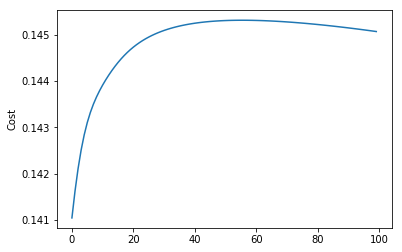

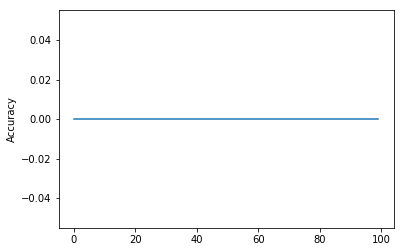

In [11]:
dataset = arff.loadarff('../data/weather.arff')
df = pd.DataFrame(dataset[0])

STR_COLUMNS = ['outlook', 'windy', 'play']

for column in STR_COLUMNS:
    df[column] = df[column].str.decode('utf-8')
    
df_encoded = pd.get_dummies(df, columns=['outlook', 'windy'])
df_encoded = pd.get_dummies(df_encoded, columns=['play'], drop_first=True)

X = df_encoded.iloc[:, :7].values
y = df_encoded.iloc[:, 7:].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17779)

model = NeuralNetwork(input_nodes=7, hidden_nodes=[8], output_nodes=1, batch_size=12)
param, costs, accs = model.train(X_train, y_train, epochs=100)

print(param)
print()
print(costs)
print()
print(accs)

plt.plot(np.array(costs).mean(axis=1))
plt.ylabel('Cost')
plt.show()

plt.plot(accs)
plt.ylabel('Accuracy')
plt.show()